### Reinforcement Learning Project!

##### How to work through this project:

- Go cell by cell and finish the marked #TODO's
- You don't need to touch the code marked between the `#---------#`. Those are puzzle pieces that your code will fit into!
  - However, I **STRONGLY** encourage you to understand every single line between those blocks. They are essential!
  - It is crucial that your variable names are what we expect them to be, or the puzzle pieces won't fit.
- Tutorials/helpful information will be placed in the `.md` cells above the "work" cells. Consult them if you are stuck.
- If you REALLY cannot find the correct code to make the cell run, consult the `[proj]-ans.ipynb`.
- The final product (what we expect to see if you run all the cells consecutively) will be placed in the `answers/` directory.
  - Chances are your output won't be the exact same (stochasticity!) but it should be similar


In [1]:
# Get used to these imports!
#----------------------------------------------------------------#
# To install: pip install numpy
import numpy as np
# To install: pip install matplotlib
import matplotlib.pyplot as plt
# To install: pip install torch (not GPU compatible)
import torch
import torch.nn as nn
# To install: pip install gymnasium[classic_control]
import gymnasium as gym

# No pip install needed
import random
from matplotlib import animation
from IPython.display import display, clear_output
#----------------------------------------------------------------#


In this project, we will be implementing DQN for Cartpole, which is a common RL benchmark from OpenAI! First, lets visualize the environment that our Deep Q-Learnign Network will operate in. You can read more about cartpole [here](https://gsurma.medium.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288)

An excerpt is provided below if you would like to understand the dynamics of the system:

> ##### A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Run the following code to visualize the system dynamics.


Pole tipped too far
Survived for 13 steps


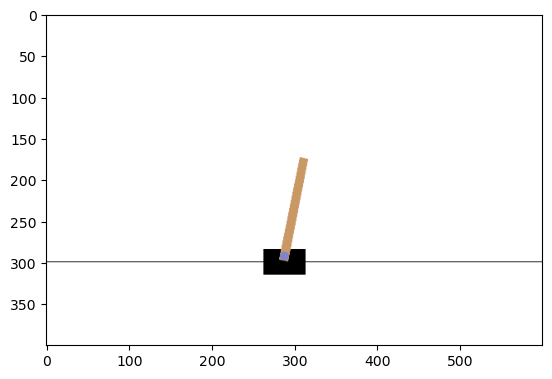

In [2]:
#----------------------------------------------------------------#
env = gym.make("CartPole-v1", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
env.reset()

num_steps_to_viz = 200
step_count = 0
for i in range(num_steps_to_viz):
    step_count += 1
    if(i % 3 == 0):  # Speed up the framerate
        plt.imshow(env.render())
        display(plt.gcf())
        clear_output(wait=True)

    _, _, terminated, truncated, _ = env.step(random.randrange(0, 2))  # take a random action
    done = terminated or truncated
    if done:
        print("Pole tipped too far")
        print(f"Survived for {step_count} steps")
        break

env.close()
#----------------------------------------------------------------#


This is what the states represent (from the environment) and what the actions do (given to the environment)

```
    Observation:
        Type: Box(4)
        Num	Observation                 Min         Max
        ------------------------------------------------------
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24°           24°
        3	Pole Velocity At Tip      -Inf            Inf

    Action:
        Type: Discrete(2)
        Num	Action
        -------------------------------
        0	Push cart to the left
        1	Push cart to the right
```

These states are returned as some weird datatypes, but a little modification can easily turn them into tensors _(you will find this a common issue, turning things to/from tensors)_


Let us first create the Deep Q-Learning Network (DQN) that will play cartpole for us. If you remember from the lesson, Q-learning is powerful because it allows for "experience replay" where transitions can be saved inside of a memory buffer and then "re-experienced" by the model to learn. Note that technically this is not the Q-function as it only operates on the state and outputes an action. **This is more analogous to a raw policy.**

Take a look at your older projects for a refresher on how to make a neural network. The specification for the network itself is detailed below.


In [3]:
# Goal: Make a DQN
# TODO: Create a neural network called DQN that has variable input and output layer sizes (input variable should be state_dim, output is action_dim).
# TODO: It should have 2+ layers with relu activations for all but the last layer. Also, the hidden layer sizes should all be 128!
"""
Tips:
- Hidden layers don't always have to be smaller than the layer before it! Especially if the input dimensionality is small
- Remind yourself what activations are and why they are useful.
- Make sure to name your class "DQN"
"""

class DQN(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(DQN, self).__init__()

    self.l1 = nn.Linear(state_dim, 128)
    self.l2 = nn.Linear(128, 128)
    self.l3 = nn.Linear(128, action_dim)

    self.relu = nn.ReLU()

  def forward(self, input):
    x = self.relu(self.l1(input))
    x = self.relu(self.l2(x))
    output = self.l3(x)
    return output


Below I have defined a "named tuple" that will store a state "transition". Essentially it will hold a previous state (`state_a`) an action taken on that state (`action`), the resultant state from taking that state-action pair (`state_b`) and the reward for taking that state-action pair.


In [4]:
#----------------------------------------------------------------#
from collections import namedtuple, deque

# Creates a named tuple that we can add to
Transition = namedtuple(
    "Transition",
    ('state_a', 'action', 'state_b', 'reward')
)

# Example of creating a named tuple

t = Transition([0, 0, 0, 0], 1, [1, 1], 0.5)

# You can check the value of, say, "action" by printing t.action

#----------------------------------------------------------------#

print(t.action)


1


We will now be implementing a memory storage class that will be accessed in the training loop to "replay" memories to make the model better. What is nice about Q-learning is that "optimization is almost always performed off-policy, which means that each update can use data collected at any point during training, regardless of how the agent was choosing to explore the environment when the data was obtained." ([Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html)). You can read more about Replay buffers [here](https://datascience.stackexchange.com/questions/20535/what-is-experience-replay-and-what-are-its-benefits)! Here are some important excerpts:

> More efficient use of previous experience, by learning with it multiple times. This is key when gaining real-world experience is costly, you can get full use of it. The Q-learning updates are incremental and do not converge quickly, so multiple passes with the same data is beneficial, especially when there is low variance in immediate outcomes (reward, next state) given the same state, action pair.

> Better convergence behaviour when training a function approximator. Partly this is because the data is more like i.i.d. data assumed in most supervised learning convergence proofs.

Implement the following class. The spec has been written for you. You can read up on the deque class [here](https://docs.python.org/3/library/collections.html#collections.deque). It is the data structure we use to store Transition tuples.


In [5]:
# Goal: Make a memory buffer storage object
# TODO: Implement the following class according to the spec
"""
Tips:
- Read up on how to use the deque object
- The random.sample() method may help you here
"""


class TransitionMemoryStorage():
    """A class to hold a buffer of transition tuples that can be sampled from to run experience replay on a DQN agent
    """

    def __init__(self, capacity):
        """Creates a buffer to hold transition tuples

        Args:
            capacity (int): How many elements the buffer can hold at a time
        """
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity

    def add_transition(self, t):
        """Adds a transition to the buffer

        Args:
            t (tuple): A Transition tuple
        """
        self.buffer.append(t)

    def sample(self, num_samples):
        """Selects num_samples unique samples from the buffer

        Args:
            num_samples (int): Number of samples to pull

        Returns:
            list: Sample list of transitions from the buffer
        """
        return random.sample(list(self.buffer), num_samples)

    def can_sample(self, num_samples):
        """Checks if there are at least num_samples samples in the buffer

        Args:
            num_samples (int): How many samples to check validity for

        Returns:
            boolean: If the TransitionMemoryStorage object can be sampled on
        """
        return len(self.buffer) >= num_samples


We will now implement an explore/exploit strategy called "epsilon-greediness". This was explained in the megadoc but if you need a refresher check out this link [here](https://www.baeldung.com/cs/epsilon-greedy-q-learning#:~:text=The%20epsilon%2Dgreedy%20approach%20selects,what%20we%20have%20already%20learned.) and read section 5.2. We will use this class when deciding wether to explore (take a random action) or exploit (use the model and hope it knows what it's doign by then).


In [6]:
import math
# TODO: Implement the following class according to the spec
"""
Tips:
- Look up ways the epsilon-greedy equation has been implemented and see which one works best here
- The `should_explore` method should have an <epsilon> probability of returning True where <epsilon> is the epsilon value at `current_step`
- Use random.random()
"""


class EpsilonGreedyStrategy():
    """Strategy for use in an agent, implements exponential decay epsilon greedy
    """

    def __init__(self, max_epsilon, min_epsilon, decay):
        """Initializes an Epsilon Greedy strategy

        Args:
            max_epsilon (float): The initial epsilon value
            min_epsilon (float): The ending epsilon value
            decay (float): The rate at which the epsilon value will decay
        """
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay

    def should_explore(self, current_step):
        """Returns True if, according to this strategy at the current timestep, the agent should explore and False otherwise

        Args:
            current_step (int): How many steps the agent has taken (persists through episodes and failures)

        Returns:
            boolean: If the agent should explore (take a random action)
        """
        if (random.random() < self._get_explore_prob(current_step)):
            return True
        return False

    def _get_explore_prob(self, current_step):
        """Returns the epsilon value at a certain timestep

        Args:
            current_step (int): The number of steps that the agent has taken

        Returns:
            float: Epsilon value at this current timestep
        """
        return self.min_epsilon + (self.max_epsilon - self.min_epsilon) * math.exp(-1. * current_step * self.decay)


Now we implement the Agent tht will actually interact with the environment. Read the tips carefully!


In [7]:
# Goal: Create an Agent class that can navigate the environment
## TODO: Implement the following class according to the spec
"""
Tips:
- Be sure to increment the step counter whenever an action is selected
- If the strategy says to explore, select a random action. Otherwise, use the model!
- The model gives you probabilities (i.e. [0.74, 0.26]) saying which action it thinks is better. Use this information to choose an action.
- Scroll up to remind yourself what integers are valid actions (and therefore return values for `select_action`)
"""
class Agent():
    """Agent that acts within the environment using a dqn policy
    """
    def __init__(self, strategy):
        """Initializes the agent with a strategy for explore vs. exploit

        Args:
            strategy: Strategy object that dictates to explore or exploit
        """
        self.strategy = strategy
        self.current_step = 0

    def select_action(self, input_state, policy_dqn):
        """Selects an action based on a state and a policy network

        Args:
            input_state: The state to select an action based on
            policy_dqn: Policy network that outputs probabilities to take actions within the action space

        Returns:
            int: Action to take based on state
        """
        self.current_step += 1
        if (self.strategy.should_explore(self.current_step)):
            return random.randint(0, 1)
        with torch.no_grad():
            return torch.argmax(policy_dqn(input_state)).item()

Finally, we get to the training loop. This is hard and requires some specific lines of code. Some is pulled from [this](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) tutorial so check it out if you are stuck.
Do the following:

- Run the code! Convince yourself that it works
- Understand how the theory we learnt is used in the `optimize_model` method. Where is the bellman equation used?
- Mess with some parameters. How sensitive is this model?

We use two networks, the policy and the target network, with a slow update on the target network to match the policy one (literally slowly shifting its weights to match the policy net). This "lagging self-tuning" ensures the model wont be caught in a self-optimization loop. After all, DQN is based on optimizing the Bellman equation, not necessarily towards maximizing reward!

The `num_episodes` parameter may have to be tweaked. Sometimes, the DQN takes 300 steps to converge to a good solution. Sometimes it takes 1000. This is the problem with DQN's, but I'm sure you will be able to get it to run!


In [8]:
#----------------------------------------------------------------#
from itertools import count
# Instantiate an EpsilonGreedyStrategy class
e_greedy_strategy = EpsilonGreedyStrategy(max_epsilon=0.9, min_epsilon=0.05, decay=0.99)

# Instantiate an agent with the above explore/exploit strategy
agent = Agent(strategy=e_greedy_strategy)

# Create a TransitionMemoryStorage object
memory = TransitionMemoryStorage(1000)

# Create a policy and target net
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)

# Set up an optimizer and loss function
optimizer = torch.optim.Adam(policy_net.parameters(), lr=0.0001)
# This is Huber loss, The Huber loss acts like the mean squared error when the error is small, but like the mean absolute error when the error is large.
loss_func = nn.SmoothL1Loss()

BATCH_SIZE = 128
GAMMA = 0.99  # Discount factor
TAU = 0.005  # Target network soft update factor


def optimize_model():
    # If the amount of Transitions saved in memory is not big enough to get a batch from, don't sample
    if not memory.can_sample(BATCH_SIZE):
        return
    transitions = memory.sample(BATCH_SIZE)

    # Batching data for easier processing
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.state_b)), dtype=torch.bool)
    non_final_next_states = torch.cat(
        [s for s in batch.state_b if s is not None])
    state_batch = torch.cat(batch.state_a)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Recall the Bellman Equation: Q(s, a) = r + (GAMMA * Q(s', a)) where a is the action selected by the agent
    # The loss we are trying to compute (a.k.a TD-error) is: loss = Q(s, a) - [r + (GAMMA * Q(s', a))]

    # This is Q(s, a), the current Q-values
    predicted_q_values = policy_net(state_batch).gather(1, action_batch)

    # These lines calculate Q(s', a) where a is the action selected by the agent
    next_state_q_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():  # This is needed because we don't want to pass in "None" values to our target_net as it would crash
        next_state_q_values[non_final_mask] = target_net(
            non_final_next_states).max(1)[0]

    # This is r + (GAMMA * Q(s', a))
    expected_q_values = reward_batch + (next_state_q_values * GAMMA)

    # Compute Huber loss
    loss = loss_func(predicted_q_values, expected_q_values.unsqueeze(1))

    # Optimize the model (standard procedure)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


def update_target(policy_net, target_net):
    """ Soft update of the target network's weights. target_net ← (policy_net*τ) + [target_net*(1-τ)]
    Args:
        policy_net : Policy DQN used to select actions
        target_net : Target DQN used to prevent self-optimization loop
    """
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()

    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key] * \
            TAU + target_net_state_dict[key]*(1-TAU)

    target_net.load_state_dict(target_net_state_dict)


num_episodes = 1000  # Number of episodes to run, can be between 200 to 1000
for i_episode in range(num_episodes):
    if(i_episode % 25 == 0):  # Sanity check every 25 episodes
        print(f"On episode {i_episode}")

    # Get the initial state of the environment
    current_state, _ = env.reset()
    # Reshape into a tensor of shape (1, 4) which is necessary for batching
    current_state = torch.tensor(
        current_state, dtype=torch.float32).unsqueeze(0)

    done = False
    while not done:
        # Select an action
        action = agent.select_action(current_state, policy_net)
        # Take a step in the environment and get the results from that step
        next_state, reward, terminated, truncated, _ = env.step(action)

        # We do not want to consider terminated transition states. This is used to mask data for model updates
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(
                next_state, dtype=torch.float32).unsqueeze(0)

        # Store the transition in memory, reshaping for batching
        memory.add_transition(Transition(current_state, torch.tensor(
            [action]).unsqueeze(0), next_state, torch.tensor([reward])))

        # Move to the next state
        current_state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        update_target(policy_net, target_net)

        # Terminated means the agent "wins" or "loses", truncated means some other failure happened. Either way, we move on
        done = terminated or truncated

print('Complete')


On episode 0
On episode 25
On episode 50
On episode 75
On episode 100
On episode 125
On episode 150
On episode 175
On episode 200
On episode 225
On episode 250
On episode 275
On episode 300
On episode 325
On episode 350
On episode 375
On episode 400
On episode 425
On episode 450
On episode 475
On episode 500
On episode 525
On episode 550
On episode 575
On episode 600
On episode 625
On episode 650
On episode 675
On episode 700
On episode 725
On episode 750
On episode 775
On episode 800
On episode 825
On episode 850
On episode 875
On episode 900
On episode 925
On episode 950
On episode 975
Complete


Now its time to test your model! The following method runs a few episodes and tells you the highest # of steps the agent was able to stay alive for across those episodes.


In [9]:
#----------------------------------------------------------------#
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

num_trials = 10000
overall_max_reward = 0

done = False
for i in range(num_trials):
    episode_reward = 0
    for t in count():
        action = agent.select_action(state, policy_net)
        state, reward, terminated, truncated, _ = env.step(action)
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        done = terminated or truncated

        episode_reward += 1
        overall_max_reward = max(episode_reward, overall_max_reward)

        if done:
            break

print(f"Longest time alive across {num_trials} trials: {overall_max_reward}")
#----------------------------------------------------------------#


Longest time alive across 10000 trials: 500


The following method visualizes one epsiode so you can see it! it will be slow since we are rendering individual frames, but you can see how much the agent has improved from the first time we visualized the model and took random steps! You will receive a letter grade based on how well your agend did!


Survived for 500 steps!
Grade: A
Complete!


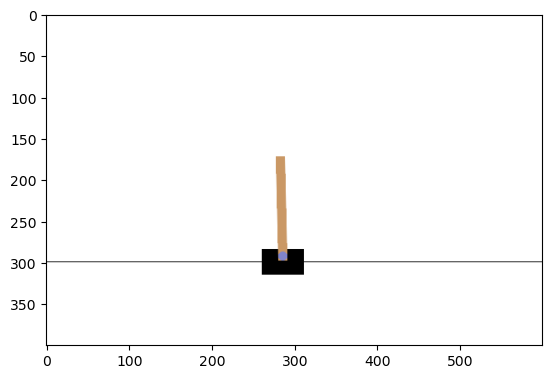

In [10]:
#----------------------------------------------------------------#
env.reset()

step_count = 0
for t in count():
    step_count += 1
    if(t % 10 == 0):
        plt.imshow(env.render())
        display(plt.gcf())
        clear_output(wait=True)

    action = agent.select_action(state, policy_net)
    state, reward, terminated, truncated, _ = env.step(action)
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    done = terminated or truncated
    if done:
        print(f"Survived for {step_count} steps!")
        if(step_count <= 50):
            print("Grade: F")
        elif((step_count > 50) and (step_count <= 100)):
            print("Grade: D")
        elif((step_count > 100) and (step_count <= 195)):
            print("Grade: C")
        elif((step_count > 195) and (step_count <= 450)):
            print("Grade: B")
        elif((step_count > 450) and (step_count <= 500)):
            print("Grade: A")
        break

env.close()
print("Complete!")
#----------------------------------------------------------------#


Extensions:

- Change up the network and other hyperparameters
- Plot reward through time using matplotlib.pyplot
- Plot moving average of reward using matplotlib.pyplot
- Implement A2C (requires research)


### Congratulations on completing the project! Check your results with the notebook in the `answers` directory and then send your final accuracy to your club/channel/mentor!
